In [5]:
# Libraries
from pathlib import Path
from matplotlib import pyplot as plt
from boutdata import collect
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution, Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import ToTensor
from functools import reduce
from typing import *
import matplotlib
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from collections import defaultdict
sns.set_style("whitegrid")

In [7]:
# Load and plot data

# Absolute path to either the BOUT output directory or an individual BOUT.dmp file.
DATA_LOCATION = Path(
	r"data/BOUT.dmp.0.nc"
 )


def load_density(path_hint: Path):
	"""Return the density field collected from BOUT output files."""
	path_hint = path_hint.expanduser().resolve()

	# If the user points at a single file we only need the parent directory.
	bout_dir = path_hint.parent if path_hint.is_file() else path_hint

	density = collect("n", path=str(bout_dir))
	return density.squeeze()


def plot_timestep(density,idx,vert=False):
	"""Plot the density at the final time step."""
	fig, ax = plt.subplots()
	contour = ax.contourf(density[idx, :, :].T)
	fig.colorbar(contour, ax=ax, label="n (arb. units)")
	ax.set_title("Density at final timestep")
	ax.set_xlabel("x index")
	ax.set_ylabel("z index")
	if vert == True:
		ax.vlines(100, 0, 1023)
	plt.show()

density_data = load_density(DATA_LOCATION)


mxsub = 8 mysub = 1 mz = 1024

nxpe = 128, nype = 1, npes = 128

Reading from 0: [0-9][0-0] -> [0-9][0-0]

Reading from 1: [2-9][0-0] -> [10-17][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading from 11: [2-9][0-0] -> [90-97][0-0]

Reading fr

### Data Info

- 128 images of the nHESEL simulation
- Width = 1028, Height = 1024

In [8]:
print(density_data[:, :, :].shape)

(93, 1028, 1024)


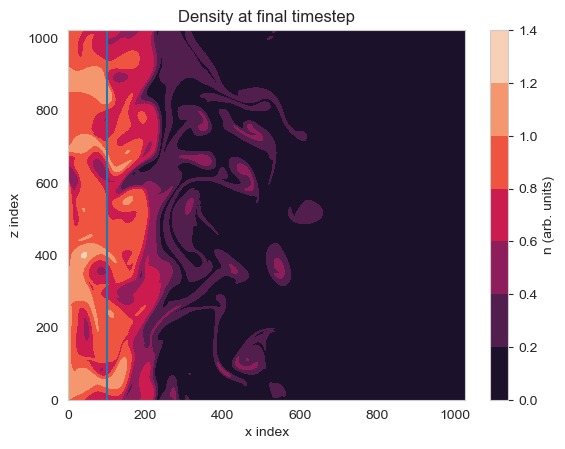

In [12]:
plot_timestep(density_data, idx=92, vert=True)

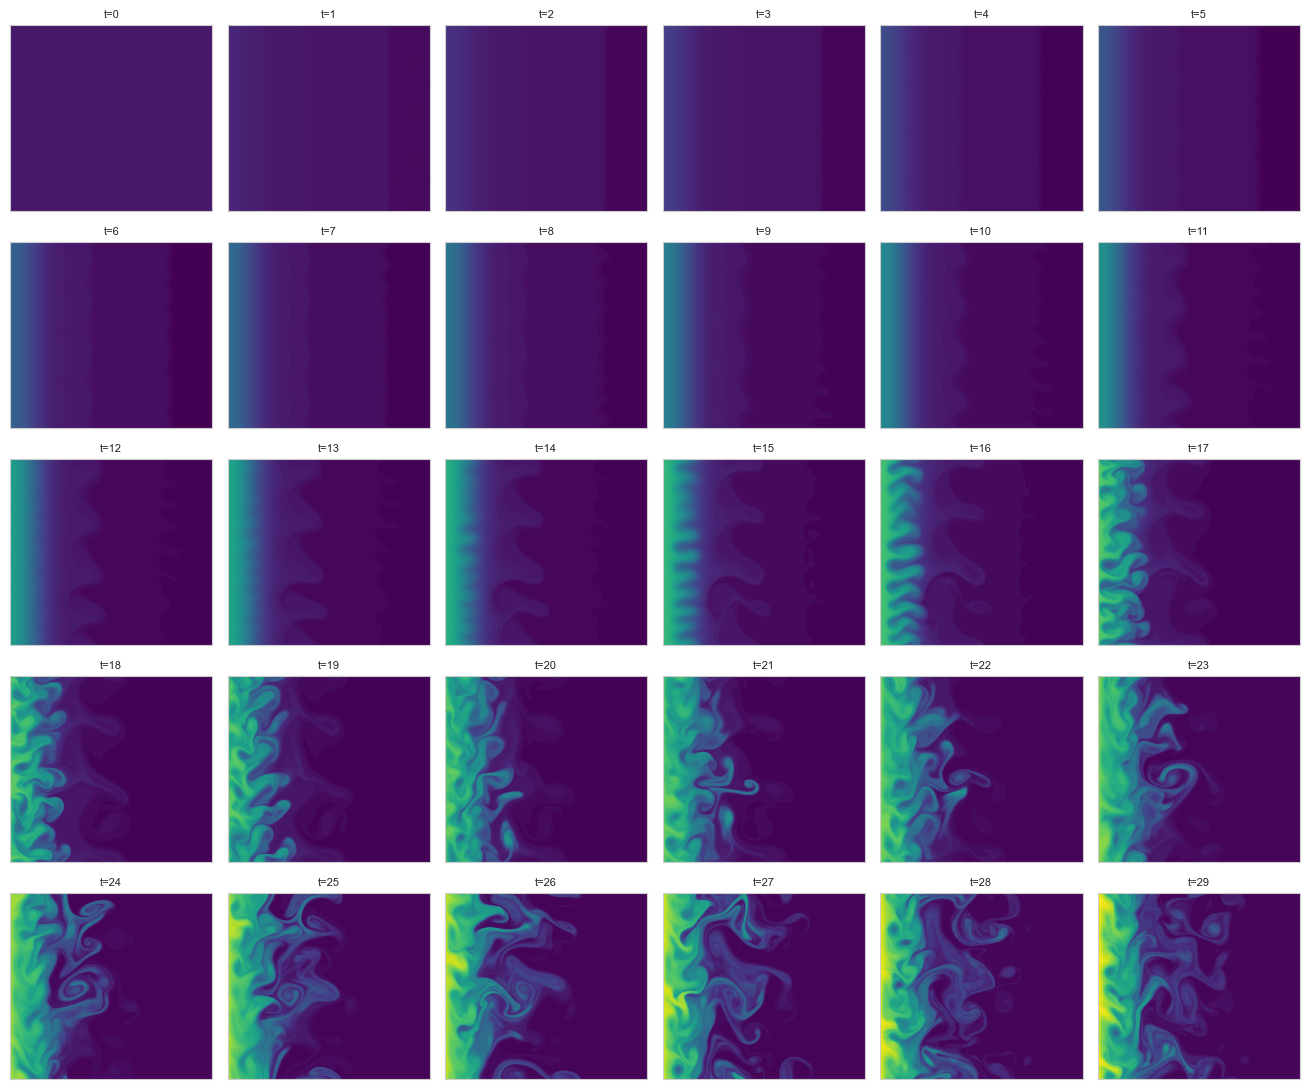

In [ ]:
# Plot first 30 timesteps in a 5x6 grid
import numpy as np

n_plots = 30
rows, cols = 5, 6

# Use the loaded density data
data = density_data

# Compute consistent color scale across all frames
vmin = float(np.min(data[:n_plots]))
vmax = float(np.max(data[:n_plots]))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.2))
for idx, ax in enumerate(axes.flat):
    im = ax.contourf(data[idx, :, :].T, levels=50, vmin=vmin, vmax=vmax, cmap="viridis")
    ax.set_title(f"t={idx}", fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])

# Single colorbar for the whole figure
plt.tight_layout()
plt.show()

# The simulation first seems to have converged at approximately 28 steps into the simulation


## VAE

In [10]:
class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        epsilon = self.sample_epsilon()
        return self.mu + self.sigma * epsilon
            
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        return -0.5 * (math.log(2 * math.pi) + 2 * torch.log(self.sigma) + ((z - self.mu) ** 2) / (self.sigma ** 2))




In [11]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, input_hw: Tuple[int, int], latent_features: int, in_channels: int = 1) -> None:
        super().__init__()
        self.input_hw = input_hw
        self.latent_features = latent_features
        self.in_channels = in_channels
        
        # Convolutional encoder keeps the code compact while extracting spatial features.
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Define encoder output dimensions
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, *input_hw)
            encoder_out = self.encoder(dummy)
        self.encoder_shape = encoder_out.shape[1:]
        self.encoder_features = int(np.prod(self.encoder_shape))
        
        self.fc_mu = nn.Linear(self.encoder_features, latent_features)
        self.fc_log_sigma = nn.Linear(self.encoder_features, latent_features)
        self.fc_decode = nn.Linear(latent_features, self.encoder_features)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(self.encoder_shape[0], 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
        
        # Prior parameters stay identical to the dense version.
        self.register_buffer("prior_params", torch.zeros(1, 2 * latent_features))
        
    def encode(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        log_sigma = self.fc_log_sigma(h)
        return mu, log_sigma
        
    def decode(self, z: Tensor) -> Tensor:
        h = self.fc_decode(z)
        h = h.view(z.size(0), *self.encoder_shape)
        return self.decoder(h)
        
    def posterior(self, x: Tensor) -> Distribution:
        mu, log_sigma = self.encode(x)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def prior(self, batch_size: int = 1) -> Distribution:
        prior_params = self.prior_params.expand(batch_size, -1)
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
        
    def observation_model(self, z: Tensor) -> Distribution:
        probs = self.decode(z).clamp(1e-6, 1 - 1e-6)
        return Bernoulli(probs=probs, validate_args=False)
        
    def forward(self, x: Tensor) -> Dict[str, Any]:
        qz = self.posterior(x)
        pz = self.prior(batch_size=x.size(0))
        z = qz.rsample()
        px = self.observation_model(z)
        return {"px": px, "pz": pz, "qz": qz, "z": z}
        
    def sample_from_prior(self, batch_size: int = 16) -> Dict[str, Any]:
        pz = self.prior(batch_size=batch_size)
        z = pz.rsample()
        px = self.observation_model(z)
        return {"px": px, "pz": pz, "z": z}


latent_features = 2
# Example usage once you have tensors shaped as (batch, 1, H, W):
# vae = VariationalAutoencoder(input_hw=(64, 64), latent_features=latent_features)
# print(sum(p.numel() for p in vae.parameters())/1e6, "M parameters")

In [12]:
density_data_tesnor = torch.as_tensor(load_density(DATA_LOCATION), dtype=torch.float32)

mxsub = 8 mysub = 1 mz = 1024

nxpe = 128, nype = 1, npes = 128

Reading from 0: [0-9][0-0] -> [0-9][0-0]

Reading from 1: [2-9][0-0] -> [10-17][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 2: [2-9][0-0] -> [18-25][0-0]

Reading from 3: [2-9][0-0] -> [26-33][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 4: [2-9][0-0] -> [34-41][0-0]

Reading from 5: [2-9][0-0] -> [42-49][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 6: [2-9][0-0] -> [50-57][0-0]

Reading from 7: [2-9][0-0] -> [58-65][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 8: [2-9][0-0] -> [66-73][0-0]

Reading from 9: [2-9][0-0] -> [74-81][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading from 11: [2-9][0-0] -> [90-97][0-0]

Reading from 10: [2-9][0-0] -> [82-89][0-0]

Reading fr

In [ ]:
latent_features = 2
VAE = VariationalAutoencoder(density_data_tesnor[0].shape,latent_features)
print(VAE)

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=4210688, out_features=2, bias=True)
  (fc_log_sigma): Linear(in_features=4210688, out_features=2, bias=True)
  (fc_decode): Linear(in_features=2, out_features=4210688, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)


In [ ]:
# Inspect all BOUT .nc files and build a dictionary of their contents
from pathlib import Path
import pprint

try:
    import xarray as xr
    xr_ok = True
except Exception:
    xr_ok = False

try:
    from netCDF4 import Dataset
    netcdf_ok = True
except Exception:
    netcdf_ok = False

data_dir = Path("data")
files = sorted(data_dir.glob("BOUT.dmp.*.nc"))

files_info = {}
for f in files:
    info = {"filesize": f.stat().st_size}
    try:
        if xr_ok:
            ds = xr.open_dataset(f)
            # collect variable shapes
            vars_info = {v: tuple(ds[v].shape) for v in ds.data_vars}
            info["vars"] = vars_info
            info["dims"] = dict(ds.dims)
            # try to infer time length
            tlen = None
            for cand in ("time", "t", "index", "step"):
                if cand in ds.dims:
                    tlen = int(ds.dims[cand])
                    break
            if tlen is None:
                if "pe" in ds:
                    try:
                        tlen = int(ds["pe"].shape[0])
                    except Exception:
                        tlen = None
            info["time_len"] = int(tlen) if tlen is not None else None
            # capture a small summary of attributes (avoid huge output)
            attrs = dict(ds.attrs)
            info["attrs_keys"] = list(attrs.keys())[:20]
            ds.close()
        elif netcdf_ok:
            ds = Dataset(f)
            vars_info = {v: tuple(ds.variables[v].shape) for v in ds.variables}
            info["vars"] = vars_info
            info["dims"] = {d: len(ds.dimensions[d]) for d in ds.dimensions}
            tlen = None
            for cand in ("time", "t", "index", "step"):
                if cand in ds.dimensions:
                    tlen = len(ds.dimensions[cand])
                    break
            if tlen is None and "pe" in ds.variables:
                try:
                    tlen = ds.variables["pe"].shape[0]
                except Exception:
                    tlen = None
            info["time_len"] = int(tlen) if tlen is not None else None
            info["attrs_keys"] = []
            ds.close()
        else:
            info["error"] = "no xarray/netCDF4 available to inspect files"
    except Exception as e:
        info["error"] = str(e)
    files_info[f.name] = info

# Summary
unique_time_lengths = sorted({v["time_len"] for v in files_info.values() if v.get("time_len") is not None})
print(f"Found {len(files)} files in {data_dir}")
print("Unique time lengths across files:", unique_time_lengths)

print('\nExample file metadata (first file):')
first = next(iter(files_info.items())) if files_info else (None, None)
if first[0] is not None:
    print(first[0])
    pprint.pprint(first[1], compact=False, width=120)

# Expose variable for later use
bout_files_info = files_info

# Display as JSON-like via IPython display if available
try:
    from IPython.display import JSON, display
    display(JSON(bout_files_info))
except Exception:
    pass
